#### 1. in this notebook, try out the following algorithms 
* Logistic Regression
* Random Forest
* SVM
* Naive bayes
* XGBoost
#### 2. try out oversampling , undersampling and adjusted class weights to midigate class imbanlance

In [1]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, average_precision_score,precision_recall_curve, make_scorer,classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('processed_lemmed.csv',index_col=False)

In [3]:
df.head(3)

,id,num_comments,score,upvote_ratio,hour,Class,body_len,lemmatized_text
0,x2wyl4,1.0,1.0,1.0,10,1,356,"['eat', 'chocolate', 'think', 'orderedeaten', ..."
1,x2uv4c,1.0,1.0,1.0,8,1,380,"['change', 'think', 'time', 'change', 'time', ..."
2,x2pn4w,1.0,1.0,1.0,4,1,732,"['nfa', 'loudly_crying_face', 'rant', 'broken'..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243702 entries, 0 to 243701
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               243702 non-null  object 
 1   num_comments     243702 non-null  float64
 2   score            243702 non-null  float64
 3   upvote_ratio     237259 non-null  float64
 4   hour             243702 non-null  int64  
 5   Class            243702 non-null  int64  
 6   body_len         243702 non-null  int64  
 7   lemmatized_text  243702 non-null  object 
dtypes: float64(3), int64(3), object(2)
memory usage: 14.9+ MB


In [5]:
df.isna().sum()

id                    0
num_comments          0
score                 0
upvote_ratio       6443
hour                  0
Class                 0
body_len              0
lemmatized_text       0
dtype: int64

In [9]:
df.upvote_ratio.describe()

count    237259.000000
mean          0.997866
std           0.029738
min           0.110000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: upvote_ratio, dtype: float64

In [10]:
df.upvote_ratio.fillna(df.upvote_ratio.mean(), inplace=True)

In [11]:
df.upvote_ratio.isna().sum()

0

In [13]:
training_data, test_data = train_test_split(df, test_size=0.1, random_state=25)
training_data, val_data= train_test_split(training_data, test_size=0.2, random_state=25)
training_data.shape, val_data.shape, test_data.shape

((175464, 8), (43867, 8), (24371, 8))

In [14]:
X_train =training_data.drop(['id','Class'],axis=1)
y_train= training_data.Class

X_val =val_data.drop(['id','Class'],axis=1)
y_val= val_data.Class

X_test =test_data.drop(['id','Class'],axis=1)
y_test= test_data.Class

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((175464, 6), (175464,), (43867, 6), (43867,), (24371, 6), (24371,))

In [15]:
y_val.value_counts(normalize=True)

0    0.958693
1    0.041307
Name: Class, dtype: float64

In [16]:
y_train.value_counts(normalize=True)

0    0.957684
1    0.042316
Name: Class, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0    0.957367
1    0.042633
Name: Class, dtype: float64

In [18]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
scaler = StandardScaler()

In [19]:
ct = make_column_transformer(
    (scaler, [0,1,2,3,4]),
    (tfidf_vect, 'lemmatized_text'))

### base model-Logistic Regression

#### 1. explore the parameter class_weight,  if set as balanced, would improve model performance

In [55]:
#LogisticRegression with none class weights
log= LogisticRegression(class_weight= None)
pipe = make_pipeline(ct, log)
log_model_0 = pipe.fit(X_train, y_train)

In [56]:
y_pred_0 = log_model_0.predict(X_val)
print(classification_report(y_val,y_pred_0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     37349
           1       0.83      0.72      0.77      1644

    accuracy                           0.98     38993
   macro avg       0.91      0.85      0.88     38993
weighted avg       0.98      0.98      0.98     38993



In [57]:
y_pred_0_prob = log_model_0.predict_proba(X_val)
y_pred_0_class=y_pred_0_prob[:,1]

In [58]:
# try using class_weight=balanced to see if the performance improves
log_balanced = LogisticRegression(class_weight='balanced')
pipe = make_pipeline(ct, log_balanced)
log_model_1 = pipe.fit(X_train, y_train)

In [59]:
y_pred_1 = log_model_1.predict(X_val)
print(classification_report(y_val,y_pred_1))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     37349
           1       0.49      0.94      0.64      1644

    accuracy                           0.96     38993
   macro avg       0.74      0.95      0.81     38993
weighted avg       0.98      0.96      0.96     38993



It is interesting that when class_weights set as balanced, which adjust inversely proportional to class frequencies in the input data, improved the recall significantly but reduced the precision significantly as well. 

In [60]:
y_pred_1_prob =log_model_1.predict_proba(X_val)
y_pred_1_class = y_pred_1_prob[:,1]

In [33]:
#try out different thresholds
y_pred_1_class = y_pred_1_prob[:,1]
y_pred_1_classes = [1 if prob > 0.4 else 0 for prob in y_pred_1_class]
print(classification_report(y_val,y_pred_1_classes))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56023
           1       0.42      0.96      0.58      2466

    accuracy                           0.94     58489
   macro avg       0.71      0.95      0.78     58489
weighted avg       0.97      0.94      0.95     58489



In [38]:
y_pred_1_class = y_pred_1_prob[:,1]
y_pred_1_classes = [1 if prob > 0.7 else 0 for prob in y_pred_1_class]
print(classification_report(y_val,y_pred_1_classes))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56023
           1       0.63      0.89      0.74      2466

    accuracy                           0.97     58489
   macro avg       0.81      0.94      0.86     58489
weighted avg       0.98      0.97      0.98     58489



In [39]:
y_pred_1_class = y_pred_1_prob[:,1]
y_pred_1_classes = [1 if prob > 0.9 else 0 for prob in y_pred_1_class]
print(classification_report(y_val,y_pred_1_classes))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56023
           1       0.79      0.78      0.78      2466

    accuracy                           0.98     58489
   macro avg       0.89      0.89      0.89     58489
weighted avg       0.98      0.98      0.98     58489



In [ ]:
# Plot the AUPRC
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    ax = plt.gca()
    ax.set_aspect('equal')

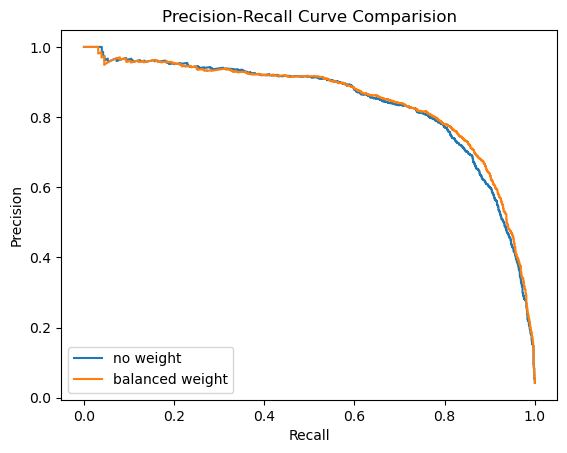

In [61]:
#put 2 PRC together
plot_prc("no weight", y_val, y_pred_0_classes
plot_prc("balanced weight", y_val, y_pred_1_classes)
plt.legend(loc="lower left")
plt.title('Precision-Recall Curve Comparision')
plt.show()

#### 3. undersampling 
keep test and validation data imbalanced, only undersample the training data

In [30]:
# Class count
count_class_0, count_class_1 = training_data.Class.value_counts()

# Divide by class
df_class_0 = training_data[training_data['Class'] == 0]
df_class_1 = training_data[training_data['Class'] == 1]
count_class_0, count_class_1

(168039, 7425)

In [31]:
df_class_0_under = df_class_0.sample(count_class_1)
df_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_under.Class.value_counts())

Random under-sampling:
0    7425
1    7425
Name: Class, dtype: int64


In [33]:
df_under.head()

,id,num_comments,score,upvote_ratio,hour,Class,body_len,lemmatized_text
36569,wqhbbs,1.0,1.0,1.0,13,0,2029,"['finally', 'found', 'perfect', 'boyfriend', '..."
231448,rcbg5r,12.0,2.0,1.0,13,0,681,"['anybody', 'feel', 'different', 'part', 'brai..."
229061,snyuhk,0.0,1.0,1.0,6,0,136,"['want', 'start', 'meditation', 'get', 'depres..."
48743,wkylzf,1.0,1.0,1.0,21,0,3427,"['enter', 'relationship', 'run', 'f', 'start',..."
81878,vjcd8m,0.0,1.0,1.0,8,0,2373,"['found', 'gfsf', 'affair', 'bosssm', 'week', ..."


In [35]:
X_train_under =df_under.drop(['id','Class'],axis=1)
y_train_under = df_under.Class
X_train_under.shape, y_train_under.shape

((14850, 6), (14850,))

In [36]:
log = LogisticRegression()
pipe = make_pipeline(ct, log)

log_model_under = pipe.fit(X_train_under, y_train_under)

In [37]:
y_pred_under = log_model_under.predict(X_val)
print(classification_report(y_val,y_pred_under))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     37349
           1       0.28      0.96      0.43      1644

    accuracy                           0.89     38993
   macro avg       0.64      0.93      0.69     38993
weighted avg       0.97      0.89      0.92     38993



traing data is too limited for the model to work well

#### 4. oversampling

In [39]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.Class.value_counts())

Random over-sampling:
0    168039
1    168039
Name: Class, dtype: int64


In [40]:
X_train_over =df_over.drop(['id','Class'],axis=1)
y_train_over = df_over.Class
y_train_over.shape, y_train_over.shape

((336078,), (336078,))

In [63]:
log = LogisticRegression()
pipe = make_pipeline(ct, log)

log_model_over = pipe.fit(X_train_over, y_train_over)

In [77]:
log_y_pred_over = log_model_over.predict(X_val)
print(classification_report(y_val,log_y_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     37349
           1       0.67      0.99      0.80      1644

    accuracy                           0.98     38993
   macro avg       0.84      0.98      0.89     38993
weighted avg       0.99      0.98      0.98     38993



Conclusion: 
1. oversamling is better than undersampling
2. oversampling results is comparable with model with balanced class weights

In [78]:
log_y_pred_over_prob = log_model_over.predict_proba(X_val)
log_y_pred_over_class=log_y_pred_over_prob[:,1]

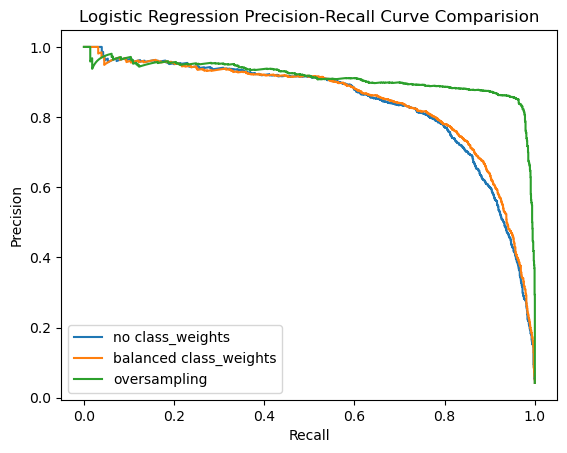

In [79]:
#put 3 PRC (no class weights, balanced class weights and oversampling) together
plot_prc("no weight", y_val, y_pred_0_classes
plot_prc("balanced weight", y_val, y_pred_1_classes)
plot_prc("oversampling", y_val, log_y_pred_over_class)

plt.title('Logistic Regression Precision-Recall Curve Comparision')
plt.legend(loc="lower left")
plt.show()

In [69]:
print('oversampling:\n', classification_report(y_val,y_pred_over))

oversampling:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     37349
           1       0.77      0.95      0.85      1644

    accuracy                           0.99     38993
   macro avg       0.88      0.97      0.92     38993
weighted avg       0.99      0.99      0.99     38993



In [70]:
print('with balanced class_weights:\n', classification_report(y_val,y_pred_1))

with balanced class_weights:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     37349
           1       0.49      0.94      0.64      1644

    accuracy                           0.96     38993
   macro avg       0.74      0.95      0.81     38993
weighted avg       0.98      0.96      0.96     38993



oversampling is the winning model for logistic regression

### Random Forest 

#### 1. try some random gyperpamaetets to get a general idea

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth=5, class_weight=None,random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_0 = pipe.fit(X_train, y_train)

In [66]:
y_pred_0 = rf_model_0.predict(X_val)
print(classification_report(y_val,y_pred_0))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56023
           1       0.00      0.00      0.00      2466

    accuracy                           0.96     58489
   macro avg       0.48      0.50      0.49     58489
weighted avg       0.92      0.96      0.94     58489



In [67]:
rf= RandomForestClassifier(max_depth=5, class_weight='balanced',random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_1 = pipe.fit(X_train, y_train)

In [68]:
y_pred_1 = rf_model_1.predict(X_val)
print(classification_report(y_val,y_pred_1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56023
           1       0.00      0.00      0.00      2466

    accuracy                           0.96     58489
   macro avg       0.48      0.50      0.49     58489
weighted avg       0.92      0.96      0.94     58489



In [99]:
rf= RandomForestClassifier(max_depth=2,n_estimators=10, 
                           class_weight='balanced_subsample',
                           random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_2 = pipe.fit(X_train, y_train)

In [100]:
y_pred_2 = rf_model_2.predict(X_val)
print(classification_report(y_val,y_pred_2))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92     56023
           1       0.09      0.27      0.14      2466

    accuracy                           0.86     58489
   macro avg       0.53      0.58      0.53     58489
weighted avg       0.93      0.86      0.89     58489



In [15]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth=2,n_estimators=20, 
                           class_weight='balanced_subsample',
                           n_jobs=-1, random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_3 = pipe.fit(X_train, y_train)

In [16]:
y_pred_3 = rf_model_3.predict(X_val)
print(classification_report(y_val,y_pred_3))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     56023
           1       0.09      0.35      0.15      2466

    accuracy                           0.83     58489
   macro avg       0.53      0.60      0.53     58489
weighted avg       0.93      0.83      0.87     58489



In [17]:
rf= RandomForestClassifier(max_depth=2,n_estimators=50, 
                           class_weight='balanced_subsample',
                           n_jobs=-1, random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_4 = pipe.fit(X_train, y_train)

In [18]:
y_pred_4 = rf_model_4.predict(X_val)
print(classification_report(y_val,y_pred_4))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91     56023
           1       0.15      0.61      0.24      2466

    accuracy                           0.84     58489
   macro avg       0.56      0.73      0.57     58489
weighted avg       0.95      0.84      0.88     58489



In [19]:
rf= RandomForestClassifier(max_depth=2,n_estimators=100, 
                           class_weight='balanced_subsample',
                           n_jobs=-1, random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_5 = pipe.fit(X_train, y_train)

In [20]:
y_pred_5 = rf_model_5.predict(X_val)
print(classification_report(y_val,y_pred_5))

              precision    recall  f1-score   support

           0       0.98      0.86      0.92     56023
           1       0.15      0.57      0.24      2466

    accuracy                           0.85     58489
   macro avg       0.57      0.71      0.58     58489
weighted avg       0.94      0.85      0.89     58489



In [22]:
rf= RandomForestClassifier(max_depth=5,n_estimators=100, 
                           class_weight='balanced_subsample',
                           n_jobs=-1, random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_6 = pipe.fit(X_train, y_train)

In [23]:
y_pred_6 = rf_model_6.predict(X_val)
print(classification_report(y_val,y_pred_6))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     56023
           1       0.22      0.62      0.33      2466

    accuracy                           0.89     58489
   macro avg       0.60      0.76      0.63     58489
weighted avg       0.95      0.89      0.92     58489



In [24]:
rf= RandomForestClassifier(max_depth=5, n_estimators=50, 
                           class_weight='balanced',random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_7 = pipe.fit(X_train, y_train)

In [25]:
y_pred_7 = rf_model_7.predict(X_val)
print(classification_report(y_val,y_pred_7))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93     56023
           1       0.18      0.58      0.28      2466

    accuracy                           0.87     58489
   macro avg       0.58      0.73      0.60     58489
weighted avg       0.95      0.87      0.90     58489



In [26]:
rf= RandomForestClassifier(max_depth=5, n_estimators=50, 
                           class_weight=None,random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_8 = pipe.fit(X_train, y_train)

In [27]:
y_pred_8 = rf_model_8.predict(X_val)
print(classification_report(y_val,y_pred_8))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56023
           1       0.00      0.00      0.00      2466

    accuracy                           0.96     58489
   macro avg       0.48      0.50      0.49     58489
weighted avg       0.92      0.96      0.94     58489



In [28]:
rf= RandomForestClassifier(max_depth=5,n_estimators=150, 
                           class_weight='balanced_subsample',
                           n_jobs=-1, random_state=42)
pipe = make_pipeline(ct, rf)
rf_model_9 = pipe.fit(X_train, y_train)

In [29]:
y_pred_9 = rf_model_9.predict(X_val)
print(classification_report(y_val,y_pred_9))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     56023
           1       0.21      0.60      0.31      2466

    accuracy                           0.89     58489
   macro avg       0.59      0.75      0.62     58489
weighted avg       0.95      0.89      0.91     58489



seems like none class weight desn't work well in our problem, which makes sense beacuse our data is highly imbalanced.

#### 2. Random search to find the best hyperparameters

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
pipe = make_pipeline(ct, rf)
cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
param_grid = {'randomforestclassifier__n_estimators': [50, 70, 100], 
              'randomforestclassifier__max_features': [2,3],
              'randomforestclassifier__criterion': ['entropy', 'gini'], 
              'randomforestclassifier__max_depth': [2, 3, 5], 
              'randomforestclassifier__class_weight':['balanced','balanced_subsample']}

CV_rf = RandomizedSearchCV(pipe, param_grid, cv=cv, n_iter=20,
                     scoring = {'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score)},
                     refit= False)
rf_model_10=CV_rf.fit(X_train, y_train)

In [34]:
pd.DataFrame(rf_model_10.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_features,param_randomforestclassifier__max_depth,param_randomforestclassifier__criterion,param_randomforestclassifier__class_weight,params,...,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,97.627852,5.462980,21.105460,4.445230,100,3,3,gini,balanced_subsample,"{'randomforestclassifier__n_estimators': 100, ...",...,0.046366,5,0.004344,0.006950,0.011295,0.001738,0.008688,0.006603,3.324262e-03,16
1,96.076332,4.881598,15.392966,2.260311,50,2,3,gini,balanced,"{'randomforestclassifier__n_estimators': 50, '...",...,0.251233,1,0.003475,0.997394,0.998262,0.001738,0.004344,0.401043,4.872740e-01,3
2,102.535812,3.096347,16.118057,1.111799,50,3,5,entropy,balanced_subsample,"{'randomforestclassifier__n_estimators': 50, '...",...,0.040637,9,0.073849,0.035621,0.001738,0.302346,0.004344,0.083579,1.124542e-01,12
3,104.885911,5.468733,24.820925,5.908866,100,2,2,gini,balanced,"{'randomforestclassifier__n_estimators': 100, ...",...,0.151381,7,0.004344,0.000869,0.998262,0.997394,0.000000,0.400174,4.879849e-01,5
4,100.733249,7.796362,17.733362,2.964366,70,3,5,gini,balanced_subsample,"{'randomforestclassifier__n_estimators': 70, '...",...,0.063356,12,0.056473,0.001738,0.005213,0.285838,0.003475,0.070547,1.095905e-01,13
5,99.074361,7.518997,14.988651,1.235575,50,2,2,gini,balanced,"{'randomforestclassifier__n_estimators': 50, '...",...,0.000042,20,0.999131,0.998262,0.998262,0.996525,1.000000,0.998436,1.152606e-03,1
6,111.680030,9.824318,16.321424,1.912531,50,3,5,entropy,balanced,"{'randomforestclassifier__n_estimators': 50, '...",...,0.037258,18,0.996525,0.002606,0.000869,0.997394,0.004344,0.400348,4.871327e-01,4
7,86.911142,4.332101,14.502382,0.678151,70,2,5,gini,balanced,"{'randomforestclassifier__n_estimators': 70, '...",...,0.094384,11,0.994787,0.998262,0.000869,0.003475,0.994787,0.598436,4.868500e-01,2
8,87.152038,3.683020,17.708504,0.945728,100,2,3,gini,balanced_subsample,"{'randomforestclassifier__n_estimators': 100, ...",...,0.019567,4,0.018245,0.003475,0.006082,0.014770,0.002606,0.009036,6.303512e-03,15
9,83.653836,2.673999,14.620156,0.900784,70,3,3,gini,balanced,"{'randomforestclassifier__n_estimators': 70, '...",...,0.093155,19,0.000000,0.999131,0.004344,0.135534,0.000000,0.227802,3.891486e-01,8


In [41]:
pd.DataFrame(rf_model_10.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,97.627852,96.076332,102.535812,104.885911,100.733249,99.074361,111.68003,86.911142,87.152038,83.653836,94.804219,83.302088,80.052982,77.896446,76.992538,76.806032,80.238102,80.086434,77.601079,76.010275
std_fit_time,5.46298,4.881598,3.096347,5.468733,7.796362,7.518997,9.824318,4.332101,3.68302,2.673999,3.543899,6.57186,2.349778,0.360559,1.067968,0.184248,1.086046,1.296503,2.587148,0.555034
mean_score_time,21.10546,15.392966,16.118057,24.820925,17.733362,14.988651,16.321424,14.502382,17.708504,14.620156,17.398499,13.078066,16.238118,13.484559,13.558881,11.803767,16.24531,16.314594,11.792148,11.807257
std_score_time,4.44523,2.260311,1.111799,5.908866,2.964366,1.235575,1.912531,0.678151,0.945728,0.900784,1.624795,1.492799,0.109742,0.12842,0.128969,0.083434,0.282847,0.423889,0.076665,0.099172
param_randomforestclassifier__n_estimators,100,50,50,100,70,50,50,70,100,70,70,50,100,70,70,50,100,100,50,50
param_randomforestclassifier__max_features,3,2,3,2,3,2,3,2,2,3,3,3,2,2,3,2,2,3,2,3
param_randomforestclassifier__max_depth,3,3,5,2,5,2,5,5,3,3,5,2,3,3,2,5,2,2,5,2
param_randomforestclassifier__criterion,gini,gini,entropy,gini,gini,gini,entropy,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,entropy,entropy
param_randomforestclassifier__class_weight,balanced_subsample,balanced,balanced_subsample,balanced,balanced_subsample,balanced,balanced,balanced,balanced_subsample,balanced,balanced,balanced_subsample,balanced,balanced_subsample,balanced,balanced_subsample,balanced_subsample,balanced_subsample,balanced,balanced
params,"{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 70, '...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 100, ...","{'randomforestclassifier__n_estimators': 50, '...","{'randomforestclassifier__n_estimators': 50, '..."


In [37]:
results=pd.DataFrame(rf_model_10.cv_results_)[['param_randomforestclassifier__n_estimators',
                                               'param_randomforestclassifier__max_features',
                                               'param_randomforestclassifier__max_depth',
                                               'param_randomforestclassifier__criterion', 
                                               'param_randomforestclassifier__class_weight', 
                                               'mean_test_precision',
                                               'mean_test_recall','rank_test_precision',
                                               'rank_test_recall']]

In [43]:

results.rename(columns={'param_randomforestclassifier__n_estimators': 'n_estimators', 
                        'param_randomforestclassifier__max_features': 'max_features',
                       'param_randomforestclassifier__max_depth': 'max_depth',
                       'param_randomforestclassifier__criterion':'criterion',
                       'param_randomforestclassifier__class_weight': 'class_weight'}, 
               inplace=True)
results.sort_values(['rank_test_precision','rank_test_recall' ]).head().T

,1,18,19,8,0
n_estimators,50,50,50,100,100
max_features,2,2,3,2,3
max_depth,3,5,2,3,3
criterion,gini,entropy,entropy,gini,gini
class_weight,balanced,balanced,balanced,balanced_subsample,balanced_subsample
mean_test_precision,0.259294,0.21817,0.176208,0.152504,0.145882
mean_test_recall,0.401043,0.202433,0.202954,0.009036,0.006603
rank_test_precision,1,2,3,4,5
rank_test_recall,3,10,9,15,16


Tesults are pretty bad, seems like random forest doeesn't handel imbalanced data well.
Try undersampling method to verify

#### 3. try undersampling method 

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth=3, max_features=2, 
                                 n_estimators=50, random_state=42)
pipe = make_pipeline(ct, rf)

rf_model_under = pipe.fit(X_train_under, y_train_under)

In [45]:
y_pred_under = rf_model_under.predict(X_val)
print(classification_report(y_val,y_pred_under))

              precision    recall  f1-score   support

           0       0.98      0.00      0.01     37349
           1       0.04      1.00      0.08      1644

    accuracy                           0.05     38993
   macro avg       0.51      0.50      0.04     38993
weighted avg       0.94      0.05      0.01     38993



The result is terrible

#### 4. try oversampling method

In [46]:
rf= RandomForestClassifier(max_depth=3, max_features=2, 
                                 n_estimators=50, random_state=42)
pipe = make_pipeline(ct, rf)

rf_model_over = pipe.fit(X_train_over, y_train_over)

y_pred_over = rf_model_over.predict(X_val)
print(classification_report(y_val,y_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     37349
           1       0.04      1.00      0.08      1644

    accuracy                           0.04     38993
   macro avg       0.52      0.50      0.04     38993
weighted avg       0.96      0.04      0.01     38993



In [47]:
rf= RandomForestClassifier(max_depth=3, max_features=2, 
                                 n_estimators=100, random_state=42)
pipe = make_pipeline(ct, rf)

rf_model_over_1 = pipe.fit(X_train_over, y_train_over)

y_pred_over_1 = rf_model_over_1.predict(X_val)
print(classification_report(y_val,y_pred_over_1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37349
           1       0.47      0.01      0.02      1644

    accuracy                           0.96     38993
   macro avg       0.72      0.51      0.50     38993
weighted avg       0.94      0.96      0.94     38993



The result is terrible too. 
Conclusion is random forest algorith doesn't handle imbalanced data well

### SVM

In [9]:
from sklearn.svm import SVC
svc = SVC(class_weight='balanced', kernel= 'linear')
pipe = make_pipeline(ct, svc)
svc_model_0 = pipe.fit(X_train, y_train)

y_pred_0 = svc_model_0.predict(X_val)
print(classification_report(y_val,y_pred_0))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     56023
           1       0.75      0.88      0.81      2466

    accuracy                           0.98     58489
   macro avg       0.87      0.93      0.90     58489
weighted avg       0.98      0.98      0.98     58489



The metric results are good, but it took 8 hours and 45 minuts to run, the training time is too long.

### Naive bayes

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer(ngram_range=(1,3))
min_max_scaler = MinMaxScaler()

ct1 = make_column_transformer(
    (min_max_scaler, [0,1,2,3,4]),
    (count_vect, 'lemmatized_text'))

In [56]:
nb = MultinomialNB(force_alpha=True)
pipe = make_pipeline(ct1, nb)
nb_model_0 = pipe.fit(X_train, y_train)

y_pred_0 = nb_model_0.predict(X_val)
print(classification_report(y_val,y_pred_0))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56023
           1       0.96      0.04      0.08      2466

    accuracy                           0.96     58489
   macro avg       0.96      0.52      0.53     58489
weighted avg       0.96      0.96      0.94     58489



In [57]:
from sklearn.naive_bayes import ComplementNB
nb = ComplementNB(force_alpha=True)
pipe = make_pipeline(ct1, nb)
nb_model_1 = pipe.fit(X_train, y_train)

y_pred_1 = nb_model_1.predict(X_val)
print(classification_report(y_val,y_pred_1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     56023
           1       0.92      0.05      0.10      2466

    accuracy                           0.96     58489
   macro avg       0.94      0.53      0.54     58489
weighted avg       0.96      0.96      0.94     58489



In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import ComplementNB

count_vect = CountVectorizer(ngram_range=(1,3))
min_max_scaler = MinMaxScaler()

ct1 = make_column_transformer(
    (min_max_scaler, [0,1,2,3,4]),
    (count_vect, 'lemmatized_text'))

In [52]:
# Undersampling
nb = ComplementNB(force_alpha=True)
pipe = make_pipeline(ct1, nb)
nb_model_under = pipe.fit(X_train_under, y_train_under)
y_pred_under = nb_model_under.predict(X_val)
print(classification_report(y_val,y_pred_under))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79     37349
           1       0.11      1.00      0.20      1644

    accuracy                           0.66     38993
   macro avg       0.56      0.82      0.49     38993
weighted avg       0.96      0.66      0.76     38993



In [53]:
# Oversampling
nb = ComplementNB(force_alpha=True)
pipe = make_pipeline(ct1, nb)
nb_model_over = pipe.fit(X_train_over, y_train_over)
y_pred_over = nb_model_over.predict(X_val)
print(classification_report(y_val,y_pred_over))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37349
           1       0.77      0.95      0.85      1644

    accuracy                           0.99     38993
   macro avg       0.88      0.97      0.92     38993
weighted avg       0.99      0.99      0.99     38993



oversampling works well with ComplementNB! let's see if works well with MultinomialNB

In [74]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(force_alpha=True)
pipe = make_pipeline(ct1, nb)
nb_model_over_1 = pipe.fit(X_train_over, y_train_over)
y_pred_over_1 = nb_model_over_1.predict(X_val)
print(classification_report(y_val,y_pred_over_1))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     37349
           1       0.77      0.95      0.85      1644

    accuracy                           0.99     38993
   macro avg       0.88      0.97      0.92     38993
weighted avg       0.99      0.99      0.99     38993



In [71]:
y_pred_nb_prob =nb_model_over_1.predict_proba(X_val)
y_pred_nb_1_class = y_pred_nb_prob[:,1]

oversampling works well with MultinomialNB as well!

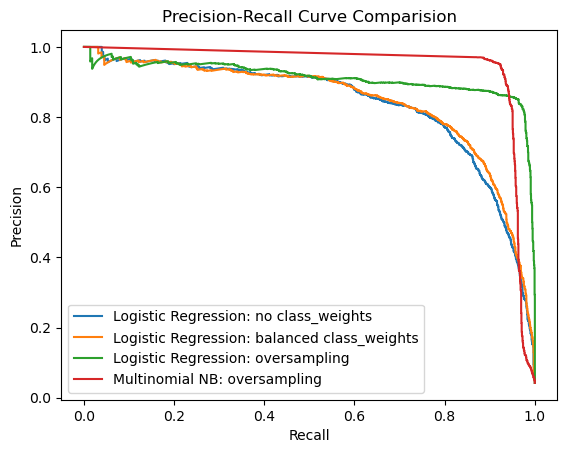

In [80]:
#plot 4 best performing model PRC 
plot_prc("Logistic Regression: no class_weights", y_val, y_pred_0_classes)
plot_prc("Logistic Regression: balanced class_weights", y_val, y_pred_1_classes)
plot_prc("Logistic Regression: oversampling", y_val, log_y_pred_over_class)
plot_prc("Multinomial NB: oversampling", y_val, y_pred_over_1)

plt.title('Precision-Recall Curve Comparision')
plt.legend(loc="lower left")
plt.show()

In [75]:
print('Multinomial NB oversampling:\n', classification_report(y_val,y_pred_over_1))

Multinomial NB oversampling:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     37349
           1       0.77      0.95      0.85      1644

    accuracy                           0.99     38993
   macro avg       0.88      0.97      0.92     38993
weighted avg       0.99      0.99      0.99     38993



In [81]:
print('Logistic Regression oversampling:\n', classification_report(y_val,log_y_pred_over))

Logistic Regression oversampling:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     37349
           1       0.67      0.99      0.80      1644

    accuracy                           0.98     38993
   macro avg       0.84      0.98      0.89     38993
weighted avg       0.99      0.98      0.98     38993



Logistic Regression oversampling has the best recall, but Multinomial NB oversampling has better precision. 

#### XGBoost

#### 1. base model with default settings

In [7]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3))
scaler = StandardScaler()

ct = make_column_transformer(
    (scaler, [0,1,2,3,4]),
    (tfidf_vect, 'lemmatized_text'))

In [61]:
# first model using default settings
from xgboost import XGBClassifier

xgb = XGBClassifier()
pipe = make_pipeline(ct, xgb)
xgb_0= pipe.fit(X_train, y_train)

In [62]:
y_pred_0 = xgb_0.predict(X_val)
print(classification_report(y_val,y_pred_0))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     56023
           1       0.92      0.88      0.90      2466

    accuracy                           0.99     58489
   macro avg       0.96      0.94      0.95     58489
weighted avg       0.99      0.99      0.99     58489



#### 2. setting max_delta_step to various values to see if it will improve our model

In [8]:
# setting max_delta_step to 5, to see if it helps with our imbalanced dataset
xgb = XGBClassifier(max_delta_step=5)
pipe = make_pipeline(ct, xgb)
xgb_1= pipe.fit(X_train, y_train)

In [9]:
y_pred_1 = xgb_1.predict(X_val)
print(classification_report(y_val,y_pred_1))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37349
           1       0.93      0.87      0.90      1644

    accuracy                           0.99     38993
   macro avg       0.96      0.93      0.95     38993
weighted avg       0.99      0.99      0.99     38993



In [10]:
xgb_1.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    [0, 1, 2, 3, 4]),
                                   ('tfidfvectorizer',
                                    TfidfVectorizer(ngram_range=(1, 3)),
                                    'lemmatized_text')])),
  ('xgbclassifier',
   XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                 grow_policy='depthwise', importance_type=None,
                 interaction_constraints='', learning_rate=0.300000012,
                 max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
                 max_delta_step=5, max_depth=6, max_leaves=0, min_child_weight=1,
                 missing=nan, monot

In [13]:
# setting max_delta_step to 2
xgb = XGBClassifier(max_delta_step=2)
pipe = make_pipeline(ct, xgb)
xgb_2= pipe.fit(X_train, y_train)

y_pred_2 = xgb_2.predict(X_val)
print(classification_report(y_val,y_pred_2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37349
           1       0.93      0.88      0.90      1644

    accuracy                           0.99     38993
   macro avg       0.96      0.94      0.95     38993
weighted avg       0.99      0.99      0.99     38993



In [17]:
# setting max_delta_step to 10
xgb = XGBClassifier(max_delta_step=10)
pipe = make_pipeline(ct, xgb)
xgb_3= pipe.fit(X_train, y_train)

y_pred_3 = xgb_3.predict(X_val)
print(classification_report(y_val,y_pred_3))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37349
           1       0.93      0.87      0.90      1644

    accuracy                           0.99     38993
   macro avg       0.96      0.93      0.95     38993
weighted avg       0.99      0.99      0.99     38993



In [18]:
y_pred_1_prob =xgb_1.predict_proba(X_val)
y_pred_1_class = y_pred_1_prob[:,1]


y_pred_2_prob =xgb_2.predict_proba(X_val)
y_pred_2_class = y_pred_2_prob[:,1]

y_pred_3_prob =xgb_3.predict_proba(X_val)
y_pred_3_class = y_pred_3_prob[:,1]


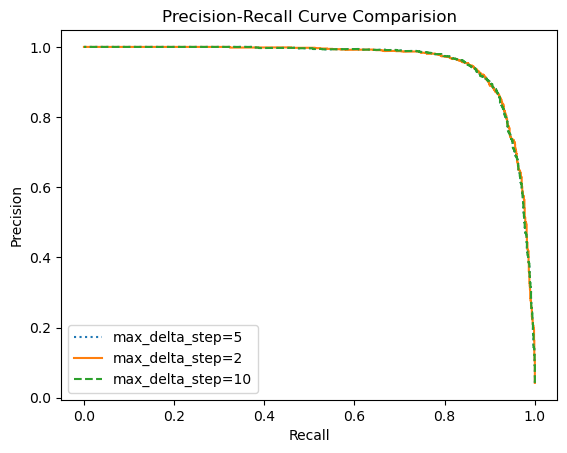

In [22]:
#put 3 PRC together
plot_roc("max_delta_step=5", y_val,y_pred_1_class, linestyle = 'dotted')
plot_roc("max_delta_step=2", y_val,y_pred_2_class, linestyle = 'solid')
plot_roc("max_delta_step=10", y_val,y_pred_3_class, linestyle = 'dashed' )

plt.title('Precision-Recall Curve Comparision')
plt.legend(loc="lower left")
plt.show()

As the plot shows, the prcs pretty uch overlap, means the the max_delta_step hyperparameter value doesn't matter.
Scores are all pretty good.

#### 3. Bayesian Optimization for XGBoost

In [86]:
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

In [87]:
X_train_transformed=ct.fit_transform(X_train)
X_val_transformed=ct.transform(X_val)

In [11]:
def objective(space):
    # Instantiate the classifier
    clf = XGBClassifier(n_estimators =int(space['n_estimators']),
                        colsample_bytree=space['colsample_bytree'],
                        learning_rate = space['learning_rate'],
                        max_depth = int(space['max_depth']),
                        min_child_weight = space['min_child_weight'],
                        subsample = space['subsample'],
                        gamma = space['gamma'],
                        reg_alpha=int(space['reg_alpha']),
                        reg_lambda = space['reg_lambda']
                       )
    
    eval_set  = [(X_train_transformed, y_train), ( X_val_transformed, y_val)]
    
    # Fit the classsifier
    clf.fit(X_train_transformed, y_train,
            eval_set=eval_set, eval_metric="aucpr",
            early_stopping_rounds=5,verbose= False)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_val_transformed)
    
    # Calculate our Metric - accuracy
    score = f1_score(y_val, pred>0.5)
    # return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -score, 'status': STATUS_OK }


In [12]:
space ={'n_estimators': hp.quniform("n_estimators", 100, 300, 40),
        'learning_rate':hp.uniform("learning_rate", 0.001, 1),
        'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_alpha': hp.uniform ('x_reg_alpha', 1,10),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        
    }
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)
print(best)

100%|████| 50/50 [13:13:18<00:00, 951.96s/trial, best loss: -0.9070351758793971]
{'learning_rate': 0.10355549209232676, 'n_estimators': 160.0, 'x_colsample_bytree': 0.9532086389415249, 'x_gamma': 0.2583287984932803, 'x_max_depth': 13.0, 'x_min_child': 3.0, 'x_reg_alpha': 2.1835785126415264, 'x_reg_lambda': 0.0017777370909676793, 'x_subsample': 0.7898503793195166}


In [13]:
print(best)

{'learning_rate': 0.10355549209232676, 'n_estimators': 160.0, 'x_colsample_bytree': 0.9532086389415249, 'x_gamma': 0.2583287984932803, 'x_max_depth': 13.0, 'x_min_child': 3.0, 'x_reg_alpha': 2.1835785126415264, 'x_reg_lambda': 0.0017777370909676793, 'x_subsample': 0.7898503793195166}


In [14]:
trials.results

[{'loss': -0.899393165122964, 'status': 'ok'},
 {'loss': -0.9001584786053883, 'status': 'ok'},
 {'loss': -0.8784241305016929, 'status': 'ok'},
 {'loss': -0.8995363214837713, 'status': 'ok'},
 {'loss': -0.8952142633719111, 'status': 'ok'},
 {'loss': -0.8905472636815921, 'status': 'ok'},
 {'loss': -0.9040752351097179, 'status': 'ok'},
 {'loss': -0.9046287666977322, 'status': 'ok'},
 {'loss': -0.8853681267474371, 'status': 'ok'},
 {'loss': -0.8983261004339739, 'status': 'ok'},
 {'loss': -0.8797061524334251, 'status': 'ok'},
 {'loss': -0.9007776049766718, 'status': 'ok'},
 {'loss': -0.8972772277227723, 'status': 'ok'},
 {'loss': -0.8965091133765832, 'status': 'ok'},
 {'loss': -0.884950248756219, 'status': 'ok'},
 {'loss': -0.8857852265673495, 'status': 'ok'},
 {'loss': -0.8983585858585859, 'status': 'ok'},
 {'loss': -0.9001545595054097, 'status': 'ok'},
 {'loss': -0.8901408450704226, 'status': 'ok'},
 {'loss': -0.8901166359729895, 'status': 'ok'},
 {'loss': -0.898932831136221, 'status': 'o

In [52]:
tpe_results=np.array([[abs(x['result']['loss']),
                       x['misc']['vals']['learning_rate'][0],
                       x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['x_colsample_bytree'][0],
                      x['misc']['vals']['x_gamma'][0],
                      x['misc']['vals']['x_max_depth'][0],
                      x['misc']['vals']['x_min_child'][0],
                      x['misc']['vals']['x_reg_lambda'][0],
                    x['misc']['vals']['x_subsample'][0],
                      ] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['f1_score', 'learning_rate','n_estimators','colsample_bytree', 'gamma', 
                                    'max_depth', 'x_min_child', 'reg_alpha', 'reg_lambda'])


In [53]:
tpe_results_df.sort_values('f1_score', ascending = False)


,f1_score,learning_rate,n_estimators,colsample_bytree,gamma,max_depth,x_min_child,reg_alpha,reg_lambda
32,0.907035,0.103555,160.0,0.953209,0.258329,13.0,3.0,0.001778,0.789850
21,0.906642,0.234329,160.0,0.771972,0.183180,15.0,10.0,0.310871,0.995411
37,0.905460,0.079720,160.0,0.854914,0.372714,13.0,5.0,0.054417,0.721535
46,0.904658,0.291077,240.0,0.716240,0.154209,8.0,1.0,0.025963,0.863436
7,0.904629,0.330935,280.0,0.949459,0.249814,11.0,7.0,0.306207,0.855647
6,0.904075,0.278649,120.0,0.786232,0.464871,14.0,9.0,0.142117,0.956203
36,0.903937,0.192076,200.0,0.717537,0.187313,15.0,2.0,0.241912,0.883497
33,0.903307,0.100957,160.0,0.993012,0.348539,13.0,3.0,0.004204,0.786326
30,0.903307,0.319298,160.0,0.701192,0.177590,14.0,4.0,0.463037,0.999532
27,0.902904,0.424776,240.0,0.759933,0.253640,14.0,6.0,0.237258,0.981733


In [54]:
tpe_results_df.to_csv('tpe_results_df.csv', index=False)

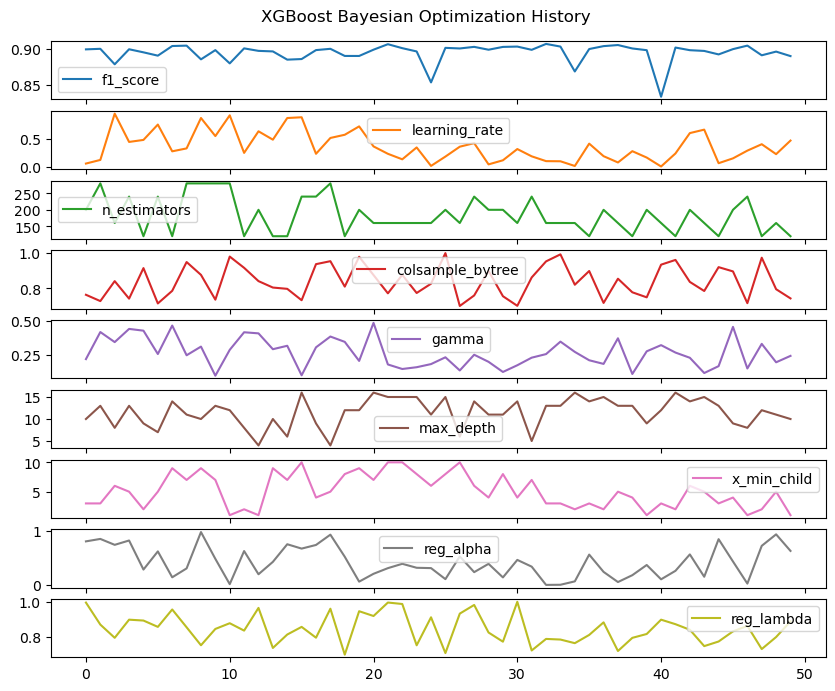

In [60]:
tpe_results_df.plot(subplots=True,figsize=(10, 8))
plt.suptitle('XGBoost Bayesian Optimization History', y=0.92)
plt.show()

In [61]:
X_test_transformed=ct.transform(X_test)

In [68]:
model = XGBClassifier(random_state=0, n_estimators=int(best['n_estimators']),
                      colsample_bytree=best['x_colsample_bytree'],
                      gamma=best['x_gamma'], 
                      learning_rate=best['learning_rate'], 
                      max_depth=int(best['x_max_depth']), 
                      reg_alpha=best['x_reg_alpha'],
                      reg_lambda=best['x_reg_lambda'],
                      min_child_weight=int(best['x_min_child']))
                      
model.fit(X_train_transformed, y_train)
xgb_val_pred = model.predict(X_val_transformed)
xgb_val_pred_prob =model.predict_proba(X_val)
xgb_val_pred_class = xgb_val_pred_prob[:,1]
print(classification_report(y_val,xgb_val_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     37349
           1       0.94      0.87      0.90      1644

    accuracy                           0.99     38993
   macro avg       0.97      0.93      0.95     38993
weighted avg       0.99      0.99      0.99     38993



In [76]:
xgb_test_pred = model.predict(X_test_transformed)
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     46686
           1       0.94      0.88      0.91      2055

    accuracy                           0.99     48741
   macro avg       0.97      0.94      0.95     48741
weighted avg       0.99      0.99      0.99     48741



In [79]:
xgb_test_pred_prob =model.predict_proba(X_test_transformed)
xgb_test_pred_class = xgb_test_pred_prob[:,1]

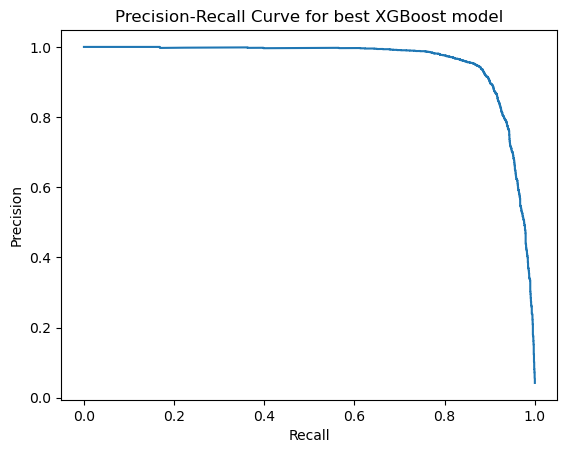

In [96]:
plt.plot('', y_val, xgb_val_pred_prob)
plt.title('Best Performing Models PRC Comparision')
plt.show()

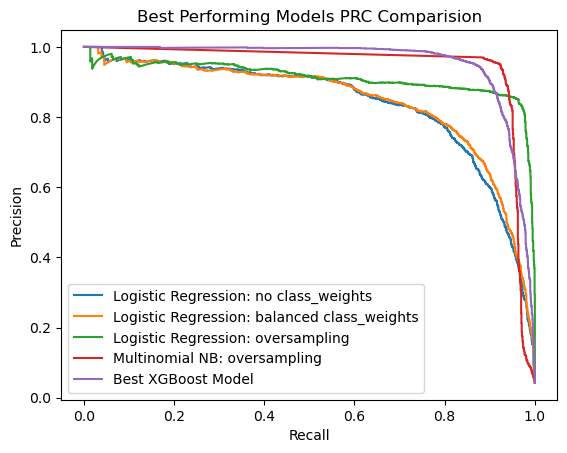

In [85]:
#plot 5 best performing model PRC 
plot_roc("Logistic Regression: no class_weights", y_val, y_pred_0_class)
plot_roc("Logistic Regression: balanced class_weights", y_val, y_pred_1_class)
plot_roc("Logistic Regression: oversampling",y_val, log_y_pred_over_class)
plot_roc("Multinomial NB: oversampling", y_val, y_pred_nb_1_class)
plot_roc("Best XGBoost Model", y_val, xgb_val_pred_prob)

plt.title('Best Performing Models PRC Comparision')
plt.legend(loc="lower left")
plt.show()

#### 4. Try oversampling for the best XGBoost model

In [88]:
best={'learning_rate': 0.10355549209232676, 'n_estimators': 160.0, 'x_colsample_bytree': 0.9532086389415249, 'x_gamma': 0.2583287984932803, 'x_max_depth': 13.0, 'x_min_child': 3.0, 'x_reg_alpha': 2.1835785126415264, 'x_reg_lambda': 0.0017777370909676793, 'x_subsample': 0.7898503793195166}

In [ ]:
X_train_over_transformed=ct.fit_transform(X_train)
X_val_transformed=ct.transform(X_val)

# setting max_delta_step to 10
xgb = XGBClassifier(max_delta_step=10)
pipe = make_pipeline(ct, xgb)
xgb_3= pipe.fit(X_train, y_train)
d
y_pred_3 = xgb_3.predict(X_val)
print(classification_report(y_val,y_pred_3))

In [90]:
xgb = XGBClassifier(random_state=0, n_estimators=int(best['n_estimators']),
                      colsample_bytree=best['x_colsample_bytree'],
                      gamma=best['x_gamma'], 
                      learning_rate=best['learning_rate'], 
                      max_depth=int(best['x_max_depth']), 
                      reg_alpha=best['x_reg_alpha'],
                      reg_lambda=best['x_reg_lambda'],
                      min_child_weight=int(best['x_min_child']))
pipe = make_pipeline(ct, xgb) 
xgb_over= pipe.fit(X_train_over, y_train_over)

xgb_over_val_pred = xgb_over.predict(X_val)
print(classification_report(y_val,xgb_over_val_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37349
           1       0.90      0.99      0.94      1644

    accuracy                           0.99     38993
   macro avg       0.95      0.99      0.97     38993
weighted avg       1.00      0.99      0.99     38993



In [92]:
xgb_over_val_pred_prob =xgb_over.predict_proba(X_val)
xgb_over_val_pred_class = xgb_over_val_pred_prob[:,1]

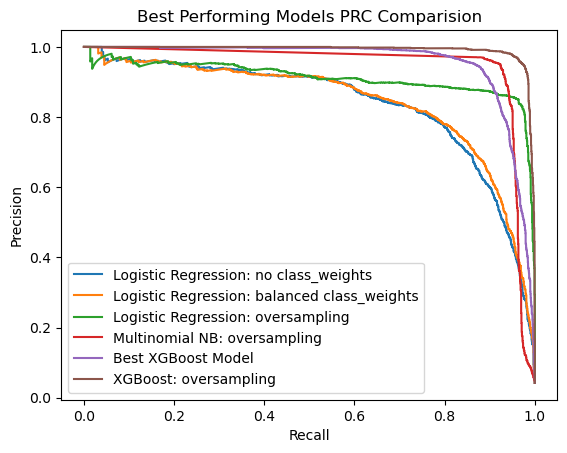

In [93]:
#plot 6 best performing model PRC 
plot_roc("Logistic Regression: no class_weights", y_val, y_pred_0_class)
plot_roc("Logistic Regression: balanced class_weights", y_val, y_pred_1_class)
plot_roc("Logistic Regression: oversampling",y_val, log_y_pred_over_class)
plot_roc("Multinomial NB: oversampling", y_val, y_pred_nb_1_class)
plot_roc("Best XGBoost Model", y_val, xgb_val_pred_class)
plot_roc("XGBoost: oversampling", y_val, xgb_over_val_pred_class)

plt.title('Best Performing Models PRC Comparision')
plt.legend(loc="lower left")
plt.show()

The winner is XGBoost using oversampling method!

In [94]:
xgb_over_test_pred = xgb_over.predict(X_test)
print(classification_report(y_test,xgb_over_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46686
           1       0.91      0.99      0.95      2055

    accuracy                           1.00     48741
   macro avg       0.95      0.99      0.97     48741
weighted avg       1.00      1.00      1.00     48741



It generalize on the test data super well! The test score is even better than val score